# Load the data

In [1]:
import json


DEVICE = 'ibm_sherbrooke'
STATE = 'X0'
ROUNDS = 50

file_name = f'../results/results_night2/{DEVICE}_{STATE}_{ROUNDS}.json'

with open(file_name, 'r') as f:
    data = json.load(f)

print(len(data))

4


In [2]:
err_dict = {}
idx = 0
for job_id, result_list in data.items():
    idx += 1
    if idx > 2:
        continue
    # if idx != 4:
    #     continue
    print(f"Job ID: {job_id}")
    nb_shots = result_list[0]['totshots']  # Number of shots for all jobs together
    for result in result_list[1:]:  # Skipping the first item as it's the total shots
        decoding_method = result['decoding']  # e.g., "gaussian"
        d_new = result['d_new']  # The 'd_new' value
        for err_type, err_rate in result['error_mean_dict'].items():
            dict_key = f"{decoding_method}_{err_type}"  # e.g., "gaussian_soft_mean"
            if dict_key not in err_dict:
                err_dict[dict_key] = {}
            if d_new not in err_dict[dict_key]:
                err_dict[dict_key][d_new] = [err_rate, nb_shots]#*len(result['error_list_dict'][err_type])]
            else:
                err_dict[dict_key][d_new][0] += err_rate
                err_dict[dict_key][d_new][1] += nb_shots#*len(result['error_list_dict'][err_type])

for key, value in err_dict.items():
    if key not in ['kde_soft_mean', 'kde_hard_mean']:
        continue
    print(f"{key}: {value}")


Job ID: cqzd9he8gdp0008fvt20
Job ID: cqzd8wbs9z7g008dpag0
kde_soft_mean: {'51': [0.0, 30140], '47': [0.0, 30140], '43': [1.5, 30140], '39': [1.5, 30140], '35': [2.5, 30140], '31': [5.0, 30140], '27': [16.5, 30140], '23': [72.33333333333333, 30140], '19': [432.0, 30140], '15': [417.5, 30140], '11': [979.8333333333333, 30140], '7': [3670.333333333333, 30140]}
kde_hard_mean: {'51': [3.0, 30140], '47': [7.5, 30140], '43': [5.5, 30140], '39': [6.0, 30140], '35': [14.0, 30140], '31': [21.5, 30140], '27': [43.5, 30140], '23': [178.33333333333331, 30140], '19': [663.0, 30140], '15': [648.5, 30140], '11': [1198.3333333333335, 30140], '7': [3894.6666666666665, 30140]}


# Plotting

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

from scipy.optimize import curve_fit

def wilson_score_interval(p, n, z=1.96):
    """
    Calculate Wilson score interval for a given success probability (p), number of trials (n), and z-score (z).
    """
    denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (p + z**2 / (2 * n) - term) / denominator
    upper = (p + z**2 / (2 * n) + term) / denominator
    return max(lower, 0), min(upper, 1)


def logical_err_rate_per_round(p, T):
    return (1-np.exp(1/T * np.log(1-2*p)))/2


def lambda_func(d, C, Lambda):
    return C * Lambda ** (-(d+1)/2)


def plot_error_rates(distances, errs, shots, label, color='black'):
    """
    Plot error rates with confidence intervals.

    Parameters:
    - distances: List of distances.
    - errs: List of error rates corresponding to the distances.
    - shots: Number of shots corresponding to each error rate.
    - label: Label for the plot legend.
    - color: (Optional) Color for the plot.
    """
    # Setup plot parameters for PRX style
    FIGURE_WIDTH_1COL = 3.404
    FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL * 2 / (1 + np.sqrt(5)) * 1.1
    font_size = 6

    plt.rcParams.update({
        'font.size': font_size,
        'figure.titlesize': 'medium',
        'figure.dpi': 1000,
        'figure.figsize': (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
        'axes.titlesize': 'medium',
        'axes.axisbelow': True,
        'xtick.direction': 'in',
        'xtick.labelsize': 'small',
        'ytick.direction': 'in',
        'ytick.labelsize': 'small',
        'image.interpolation': 'none',
        'legend.fontsize': font_size,
        'axes.labelsize': font_size,
        'axes.titlesize': font_size,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'font.family': 'sans-serif',
    })

    # Calculate Wilson score intervals for confidence
    lowers = []
    uppers = []
    ps = []
    for err_nb, n in zip(errs, shots):
        p = err_nb / n
        lower, upper = wilson_score_interval(p, n)
        ps.append(p)
        lowers.append(lower)
        uppers.append(upper)

    # ps = np.array(ps)
    # distances = np.array(distances, dtype=int)
    # e_L = logical_err_rate_per_round(ps, T = ROUNDS)
    # print(f"e_L: {e_L}")

    # # Fit
    # popt, pcov = curve_fit(lambda_func, distances, e_L)
    # C, Lambda = popt

    # print(np.min(distances), np.max(distances))
    # distances_lin = np.linspace(np.min(distances), np.max(distances), 100)
    # e_L_fit = lambda_func(distances_lin, C, Lambda)

    # plt.plot(distances_lin, e_L_fit, 'r--', label=f'Fit: C={C:.2f}, $\Lambda$={Lambda:.2f}', linewidth=1)

    # Plot error rates and confidence intervals
    plt.plot(distances, ps, label=label, marker='o', color=color, markersize=2, linewidth=1)
    plt.fill_between(distances, lowers, uppers, color='black', alpha=0.1)

    plt.yscale("log")
    plt.ylabel('Logical Error Rate')
    plt.xlabel('Distance')
    plt.grid(True, which="both", linestyle='--', linewidth=0.2)
    plt.xticks(distances)
    # plt.yticks(ticks=[0.0001, 0.001, 0.01, 0.1], labels=["0.01%", "0.1%", "1%", "10%"])
    plt.legend(fontsize=3)


/var/folders/_3/n7zzdff5239886c9gmhrk6yr0000gn/T/ipykernel_58427/2413331858.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('Dark2', num_methods)


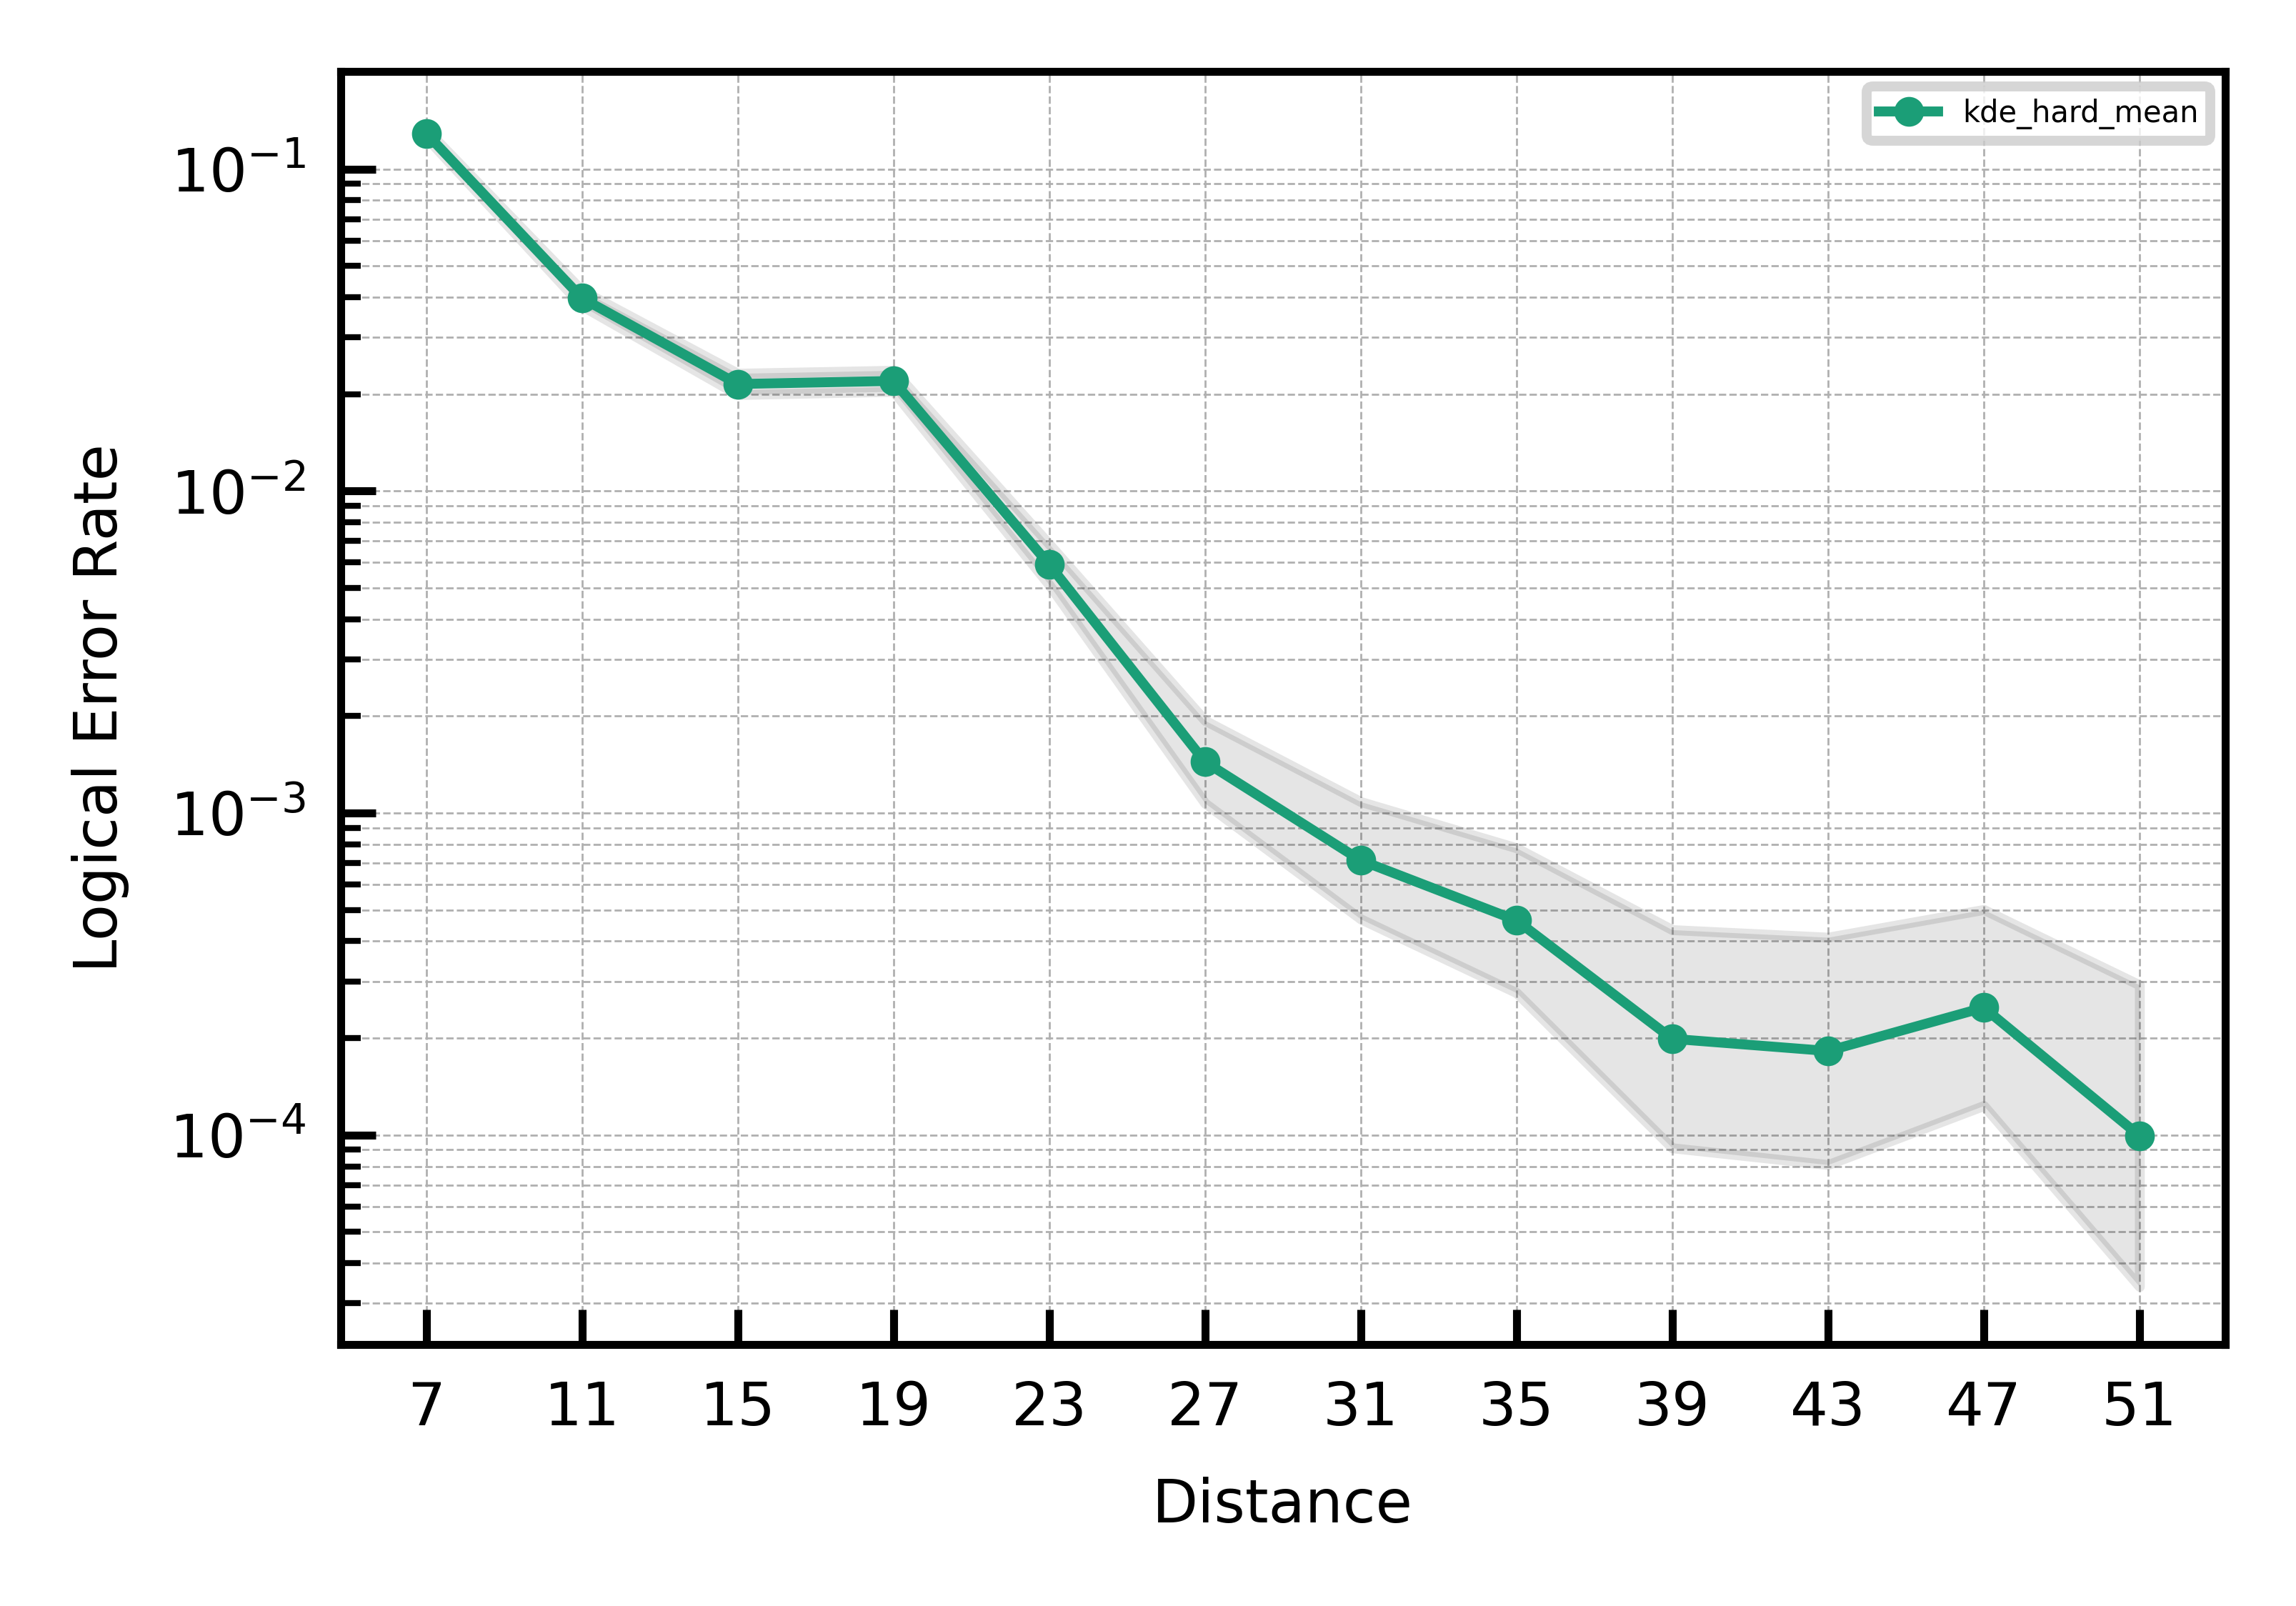

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Criteria for inclusion and exclusion
to_skip = ['indiv', 'PS', 'mean_50', 'mean_mean', 'soft']
to_have = ['kde']

num_methods = sum(not any(x in method for x in to_skip) and any(x in method for x in to_have) for method in err_dict.keys())
colors = cm.get_cmap('Dark2', num_methods)
current_method_index = 0
for i, (method, dist_dict) in enumerate(err_dict.items()):
    if not any(x in method for x in to_have) or any(x in method for x in to_skip):
        continue

    distances = list(dist_dict.keys())[::-1]
    errs = [v[0] for v in dist_dict.values()][::-1]
    nb_shots = [v[1] for v in dist_dict.values()][::-1]

    color = colors(current_method_index / (num_methods ))
    plot_error_rates(distances, errs, nb_shots, label=method, color=color)

    current_method_index += 1



# Lambda factors

e_L: [2.98104831e-03 8.27890062e-04 4.39665221e-04 4.49715765e-04
 1.19028233e-04 2.89062003e-05 1.42767380e-05 9.29421157e-06
 3.98219698e-06 3.65028787e-06 4.97798909e-06 1.99090423e-06]


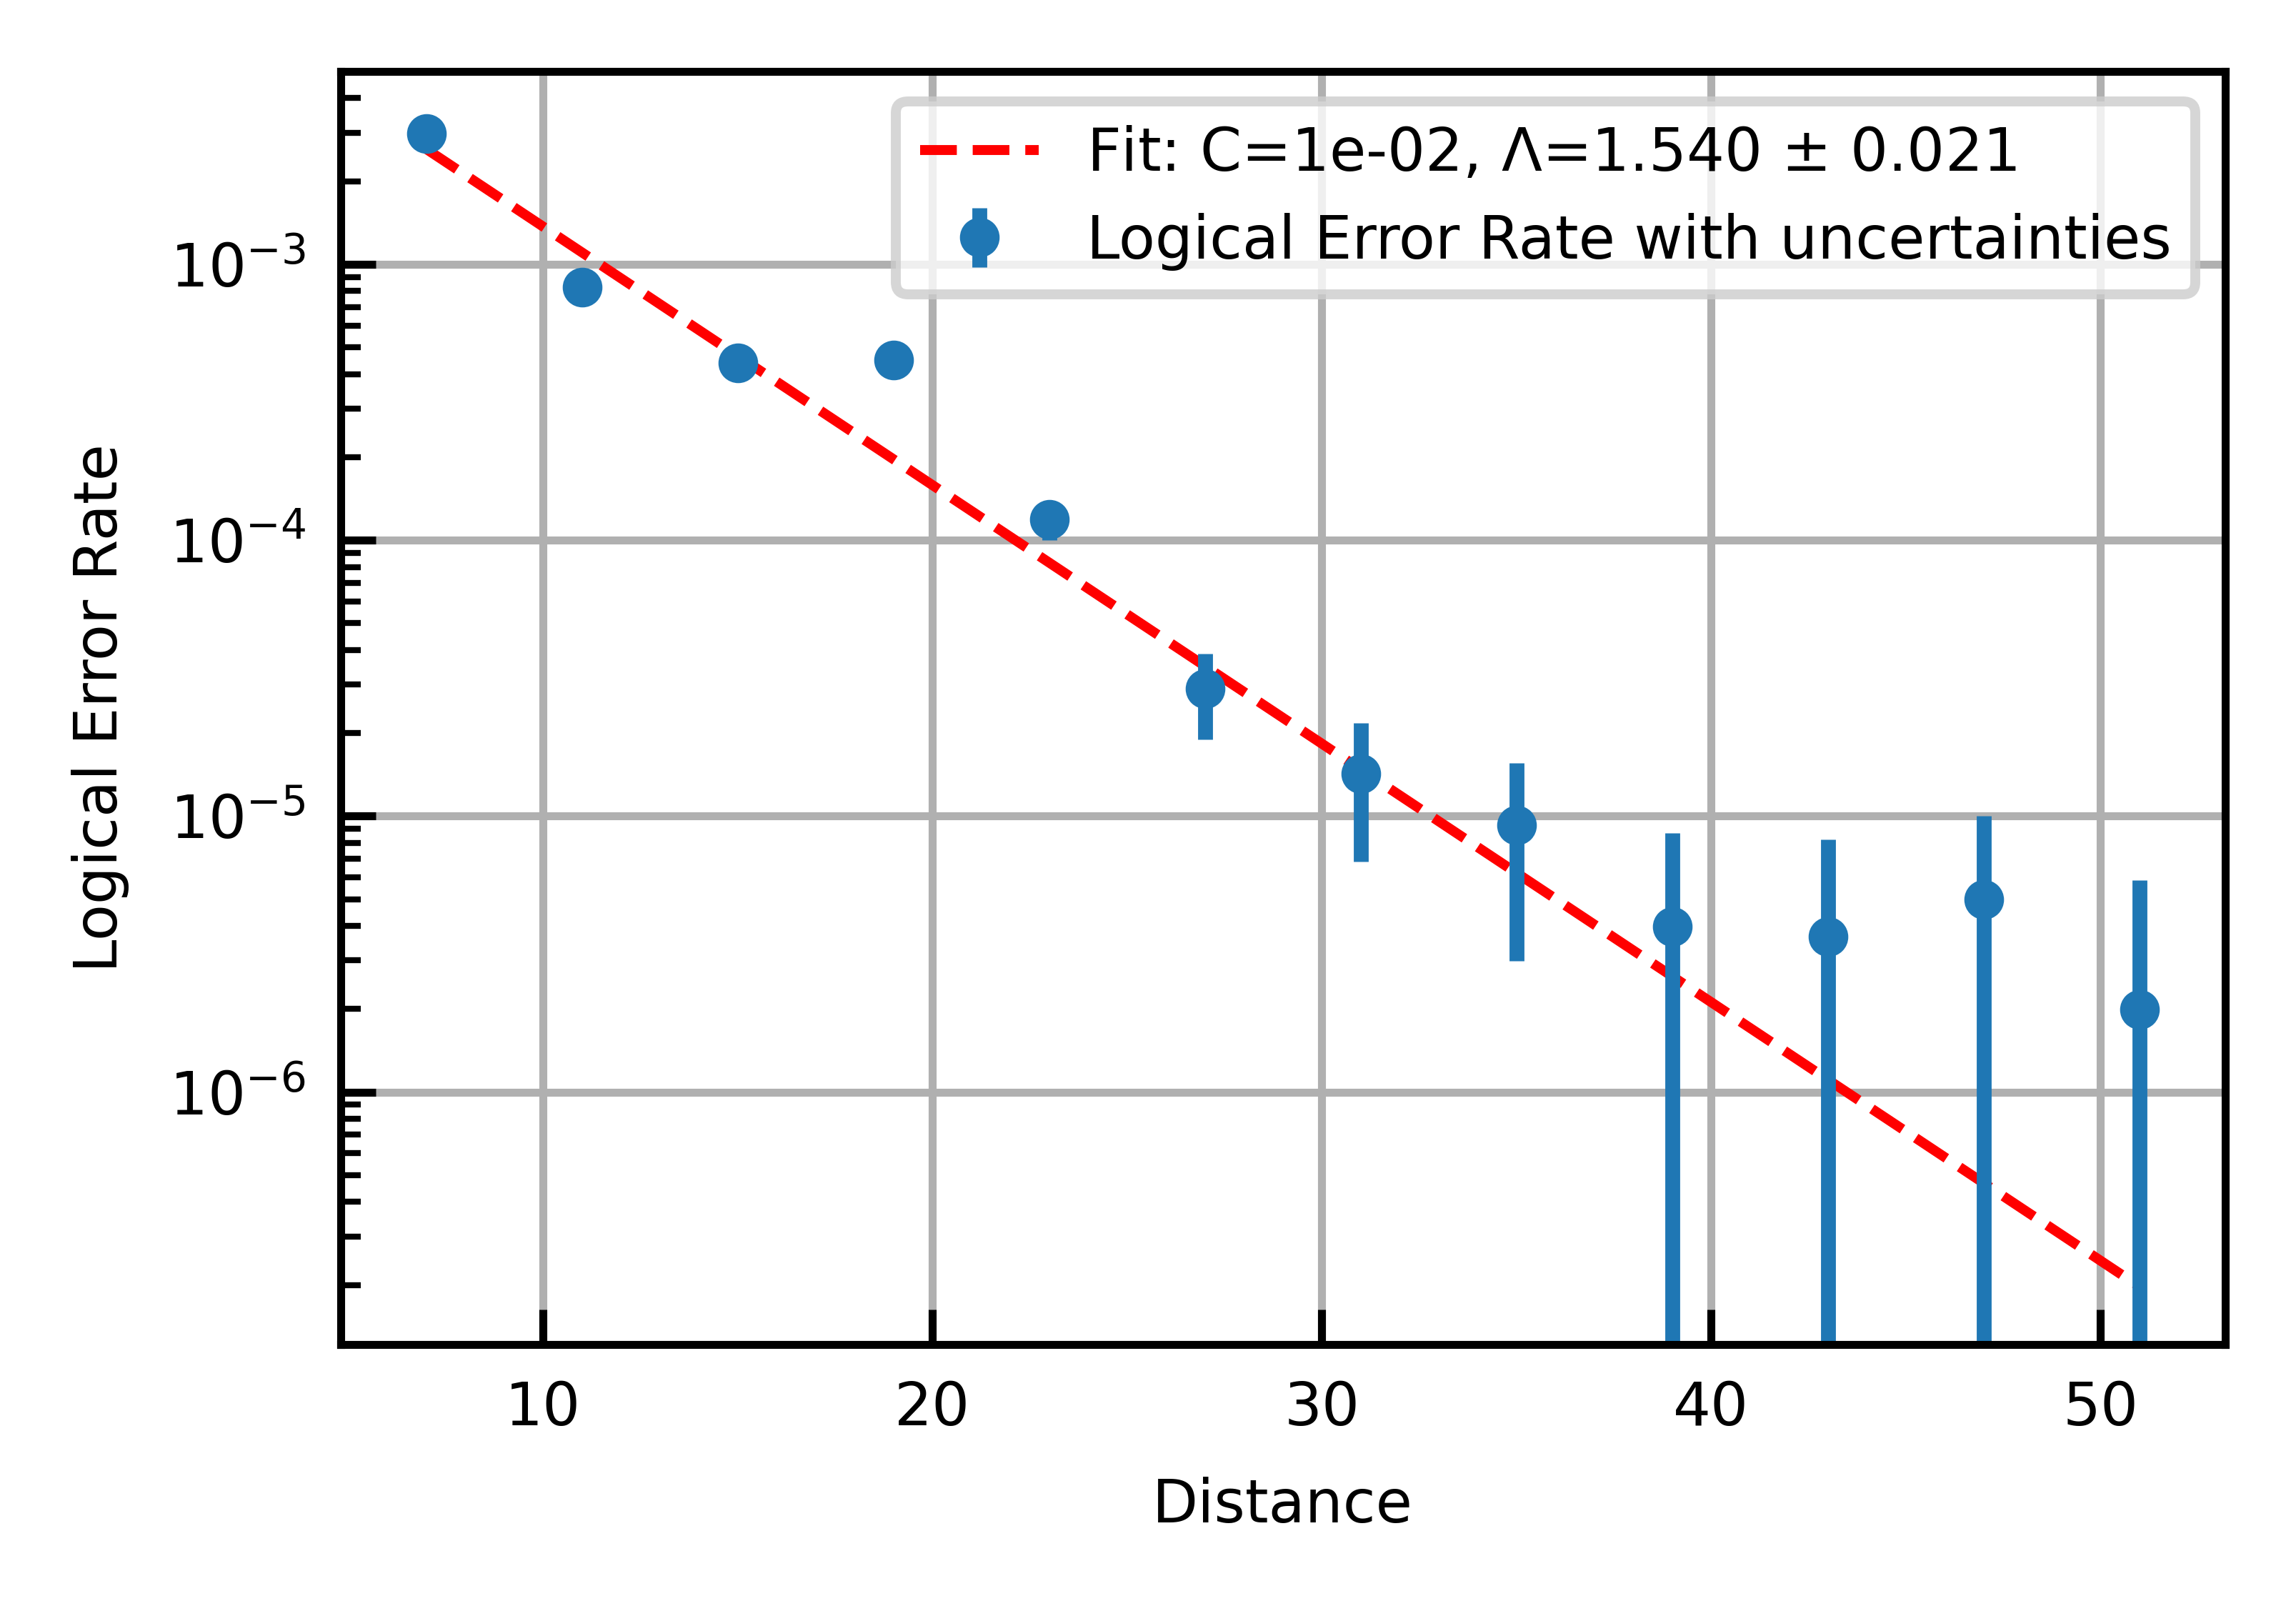

In [5]:
ps = np.array([err/shots for err, shots in zip(errs, nb_shots)])
distances = np.array(distances, dtype=int)
e_L = logical_err_rate_per_round(ps, T=ROUNDS)
print(f"e_L: {e_L}")

# Calculate Wilson score intervals for uncertainties
wilson_intervals = [wilson_score_interval(p, n) for p, n in zip(ps, nb_shots)]
lower_bounds = [interval[0] for interval in wilson_intervals]
upper_bounds = [interval[1] for interval in wilson_intervals]

# Convert lower and upper bounds of p to e_L
lower_e_L = logical_err_rate_per_round(np.array(lower_bounds), T=ROUNDS)
upper_e_L = logical_err_rate_per_round(np.array(upper_bounds), T=ROUNDS)

# Calculate uncertainties for e_L
uncertainties_lower_e_L = e_L - lower_e_L
uncertainties_upper_e_L = upper_e_L - e_L
uncertainties_e_L = np.maximum(uncertainties_lower_e_L, uncertainties_upper_e_L)

# Remove the first IDX element from all lists
IDX = 0
distances = distances[IDX:]
e_L = e_L[IDX:]
uncertainties_e_L = uncertainties_e_L[IDX:]

# Fit a curve
popt, pcov = curve_fit(lambda_func, distances, e_L, sigma=uncertainties_e_L, absolute_sigma=True)
C, Lambda = popt
lambda_error = np.sqrt(pcov[1, 1])  # Extracting the error for Lambda from the covariance matrix

# Plot the fit
plt.plot(distances, lambda_func(distances, C, Lambda), 'r--', label=f'Fit: C={C:.2f}, $\Lambda$={Lambda:.2f}', linewidth=1)

# Plot the data with error bars
plt.errorbar(distances, e_L, yerr=uncertainties_e_L, fmt='o', markersize=3, label='Logical Error Rate with uncertainties')

# Add legend with lambda error bounds
plt.legend([f'Fit: C={C:.0e}, $\Lambda$={Lambda:.3f} $\pm$ {lambda_error:.3f}', 'Logical Error Rate with uncertainties'])

plt.yscale("log")
plt.xlabel('Distance')
plt.ylabel('Logical Error Rate')
plt.grid(True)
plt.show()


In [6]:
# Derivates

e_L: [2.98104831e-03 8.27890062e-04 4.39665221e-04 4.49715765e-04
 1.19028233e-04 2.89062003e-05 1.42767380e-05 9.29421157e-06
 3.98219698e-06 3.65028787e-06 4.97798909e-06 1.99090423e-06]
C: 0.016166831664183326, Lambda: 1.5603524086722855


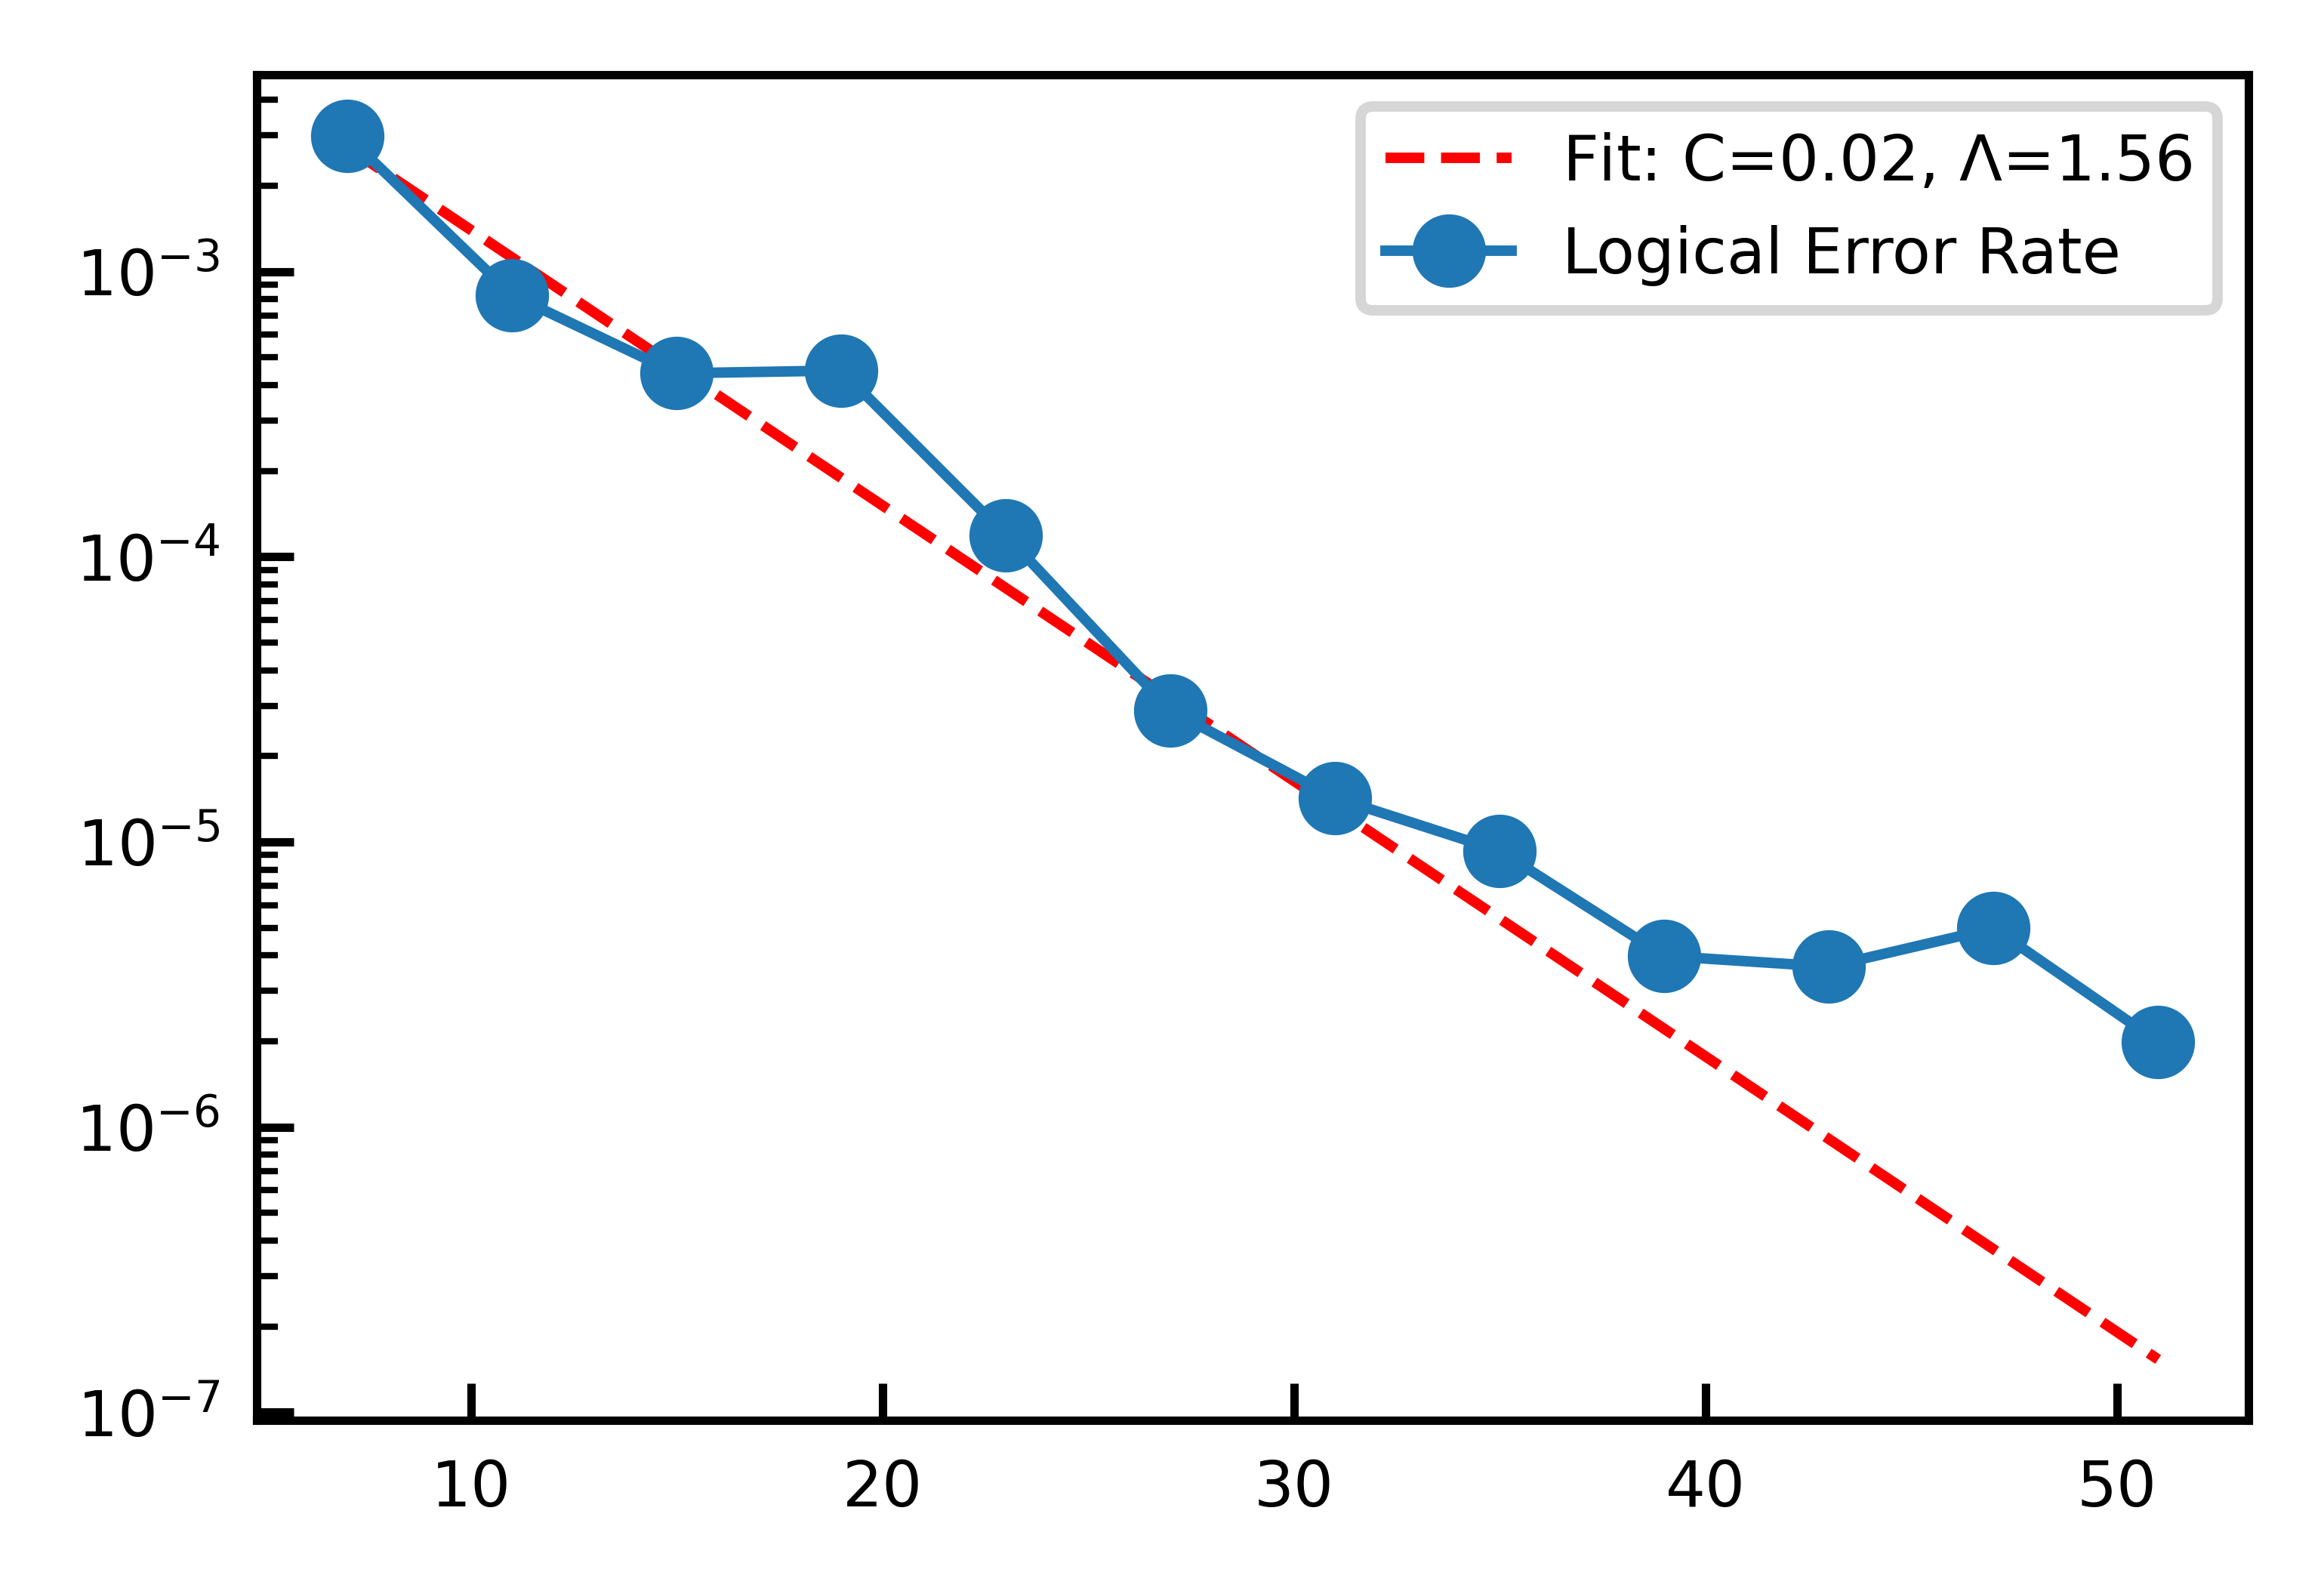

In [7]:
ps = np.array([err/shots for err, shots in zip(errs, nb_shots)])
distances = np.array(distances, dtype=int)
e_L = logical_err_rate_per_round(ps, T=ROUNDS)
print(f"e_L: {e_L}")

# Calculate Wilson score intervals for uncertainties
wilson_intervals = [wilson_score_interval(p, n) for p, n in zip(ps, nb_shots)]
lower_bounds = [interval[0] for interval in wilson_intervals]
upper_bounds = [interval[1] for interval in wilson_intervals]
uncertainties = np.array([(upper - lower) / 2 for lower, upper in zip(lower_bounds, upper_bounds)]) 

# # Pop the first INDEX points
# INDEX = 2
# ps = ps[INDEX:]
# distances = distances[INDEX:]
# e_L = e_L[INDEX:]
# uncertainties = uncertainties[INDEX:]

# Fit a curve
popt, pcov = curve_fit(lambda_func, distances, e_L, sigma=uncertainties, absolute_sigma=True)
C, Lambda = popt
print(f"C: {C}, Lambda: {Lambda}")

plt.plot(distances, lambda_func(distances, C, Lambda), 'r--', label=f'Fit: C={C:.2f}, $\Lambda$={Lambda:.2f}', linewidth=1)
plt.plot(distances, e_L, marker='o', label=f'Logical Error Rate', linewidth=1)
plt.yscale("log")
plt.legend()


# Widget plotting

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

def wilson_score_interval(p, n, z=1): #1.96 for 95% confidence
    """
    Calculate Wilson score interval for a given success probability (p), number of trials (n), and z-score (z).
    """
    denominator = 1 + z**2 / n
    term = z * np.sqrt(p * (1 - p) / n + z**2 / (4 * n**2))
    lower = (p + z**2 / (2 * n) - term) / denominator
    upper = (p + z**2 / (2 * n) + term) / denominator
    return max(lower, 0), min(upper, 1)

def plot_error_rates(distances, errs, shots, ax, label, color='black'):
    """
    Plot error rates with confidence intervals.

    Parameters:
    - distances: List of distances.
    - errs: List of error rates corresponding to the distances.
    - shots: Number of shots corresponding to each error rate.
    - label: Label for the plot legend.
    - color: (Optional) Color for the plot.
    """
    # Setup plot parameters for PRX style
    FIGURE_WIDTH_1COL = 3.404
    FIGURE_HEIGHT_1COL_GR = FIGURE_WIDTH_1COL * 2 / (1 + np.sqrt(5)) * 1.1
    font_size = 6

    plt.rcParams.update({
        'font.size': font_size,
        'figure.titlesize': 'medium',
        'figure.dpi': 100,
        'figure.figsize': (FIGURE_WIDTH_1COL, FIGURE_HEIGHT_1COL_GR),
        'axes.titlesize': 'medium',
        'axes.axisbelow': True,
        'xtick.direction': 'in',
        'xtick.labelsize': 'small',
        'ytick.direction': 'in',
        'ytick.labelsize': 'small',
        'image.interpolation': 'none',
        'legend.fontsize': font_size,
        'axes.labelsize': font_size,
        'axes.titlesize': font_size,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'font.family': 'sans-serif',
    })

    # Calculate Wilson score intervals for confidence
    lowers = []
    uppers = []
    ps = []
    for err_nb, n in zip(errs, shots):
        p = err_nb / n
        lower, upper = wilson_score_interval(p, n)
        ps.append(p)
        lowers.append(lower)
        uppers.append(upper)

    # Plot error rates and confidence intervals
    ax.plot(distances, ps, label=label, marker='o', color=color, markersize=2, linewidth=1)
    ax.fill_between(distances, lowers, uppers, color='black', alpha=0.1)

    ax.set_yscale("log")
    ax.set_ylabel('Logical Error Rate')
    ax.set_xlabel('Distance')
    ax.grid(True, which="both", linestyle='--', linewidth=0.2)
    ax.set_xticks(distances)
    # ax.set_yticks(ticks=[0.0001, 0.001, 0.01, 0.1], labels=["0.01%", "0.1%", "1%", "10%"])
    ax.legend(fontsize=3)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


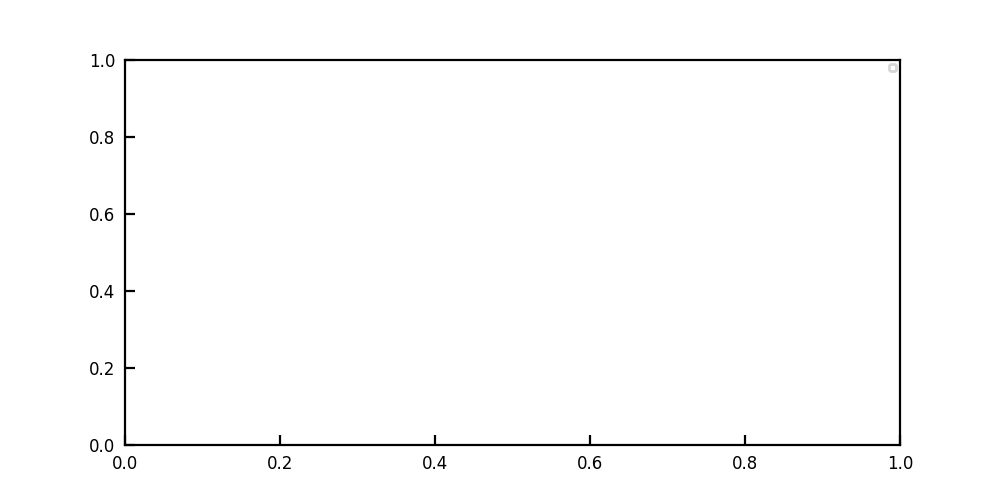

In [9]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

fig, ax = plt.subplots(dpi=200, figsize=(5, 2.5))   

def interactive_plot_with_checkboxes(err_dict):
    color_map_selector = widgets.Dropdown(
        options=['tab20', 'tab10', 'Set3', 'Set2', 'Set1', 'Dark2'],
        value='tab20',
        description='Color Map:',
    )

    checkboxes = [widgets.Checkbox(description=method, value=False, indent=False) for method in err_dict.keys()]
    num_per_row = max(1, len(checkboxes) // 3)  # Aim for 3 rows, adjust as needed

    # Create rows of checkboxes
    hbox_list = []
    for i in range(0, len(checkboxes), num_per_row):
        hbox = widgets.HBox(checkboxes[i:i+num_per_row])
        hbox_list.append(hbox)

    def update_plot(btn=None):
        selected_color_map = color_map_selector.value
        ax.clear()
        
        for checkbox in checkboxes:
            if checkbox.value:
                method = checkbox.description
                dist_dict = err_dict[method]
                distances = np.array(list(dist_dict.keys()))[::-1]
                errs = np.array([v[0] for v in dist_dict.values()])[::-1]
                shots = np.array([v[1] for v in dist_dict.values()])[::-1]
                plot_error_rates(distances, errs, shots, ax, label=method, color=plt.get_cmap(selected_color_map)(checkboxes.index(checkbox) / len(checkboxes)))
        
        ax.legend(fontsize=3)
        fig.canvas.draw_idle()

    plot_button = widgets.Button(description="Update Plot")
    plot_button.on_click(update_plot)

    display_widgets = widgets.VBox([color_map_selector] + hbox_list + [plot_button])
    display(display_widgets)

    update_plot()

interactive_plot_with_checkboxes(err_dict)
